Created by Martin Knudsen (martin.knudsen(at)tum.de), July 2019.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import circulant
from sympy import Eq, Symbol, diff, sin, exp, pi, lambdify, cos
import seaborn as snb
snb.set()

Find L-periodic solution with zero mean to:
$$-\phi '' (x) = \rho (x), \quad x \in R , \quad \int_0^L \phi(x)dx=0$$
Discretize the domain for N equally spaced points

1. 4th order finite difference:
derived via Taylor series it looks like:
$$\phi_i ''=\frac{-\frac{1}{12} \phi_{i-2} +\frac{4}{3} \phi_{i-1} -\frac{5}{2} \phi_{i}+\frac{4}{3} \phi_{i+1}-\frac{1}{12} \phi_{i+2}}{h_x^2}$$

In order for the system to not be ill conditioned we impose the mean 0 by setting all entries of the last row to 1, meaning the sum of all points is zero. 

In [2]:
def systemMatrix(N, a, b):
    h=(b-a)/N
    firstRow = np.zeros(N)
    firstRow[0:3] = [ -5/2, 4/3, -1/12]
    firstRow[-2]=-1/12
    firstRow[-1]=4/3
    # using the scipy circulant function
    A = circulant(firstRow)
    A *= -1/h**2
    # now we set the last row to 1's to make the average zero
    A[-1]=np.ones(N)
    print('This is the smallest eigval')
    print(min(abs(np.linalg.eigvals(A))))
    return A

Here's how it looks

In [3]:
print(systemMatrix(8, 0, 1))

This is the smallest eigval
9.23854714184624
[[160.         -85.33333333   5.33333333  -0.          -0.
   -0.           5.33333333 -85.33333333]
 [-85.33333333 160.         -85.33333333   5.33333333  -0.
   -0.          -0.           5.33333333]
 [  5.33333333 -85.33333333 160.         -85.33333333   5.33333333
   -0.          -0.          -0.        ]
 [ -0.           5.33333333 -85.33333333 160.         -85.33333333
    5.33333333  -0.          -0.        ]
 [ -0.          -0.           5.33333333 -85.33333333 160.
  -85.33333333   5.33333333  -0.        ]
 [ -0.          -0.          -0.           5.33333333 -85.33333333
  160.         -85.33333333   5.33333333]
 [  5.33333333  -0.          -0.          -0.           5.33333333
  -85.33333333 160.         -85.33333333]
 [  1.           1.           1.           1.           1.
    1.           1.           1.        ]]


Lets test it out on the previous worksheets periodic example. This is actually the method of manufactored solutions

In [4]:
def periodicSolverZeroMean(a, b, N, rho):
    h = (b-a)/N
    A = systemMatrix(N=N, a=a, b=b)
    xlist = [a+i*h for i in range(N-1)]
    rightSide = np.array([rho(x) for x in xlist])
    # remember to set the last row equal to 0
    rightSide = np.append(rightSide, [0])
    x = np.linalg.solve(A,rightSide)
    return x

This is the smallest eigval
0.9959984483561433
This is the smallest eigval
0.9997393731716193
This is the smallest eigval
0.9999835418044016
This is the smallest eigval
0.9999989687039642
This is the smallest eigval
0.9999999355021563
This is the smallest eigval
0.9999999959691354


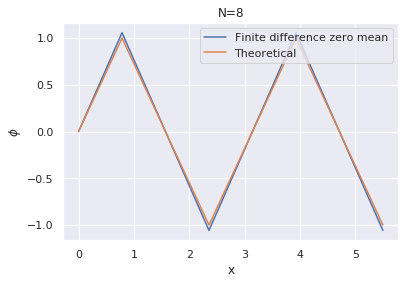

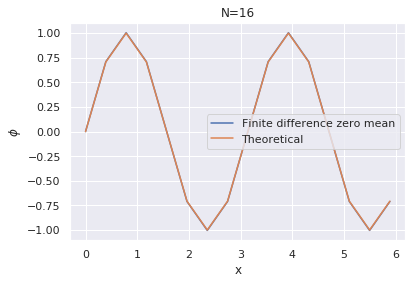

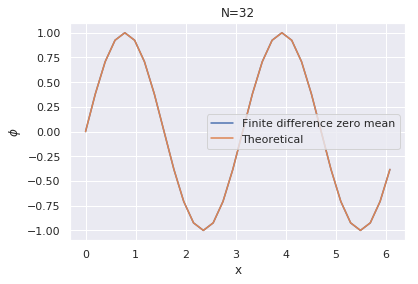

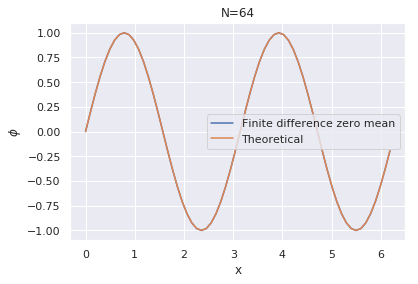

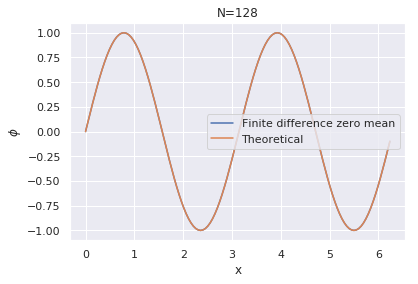

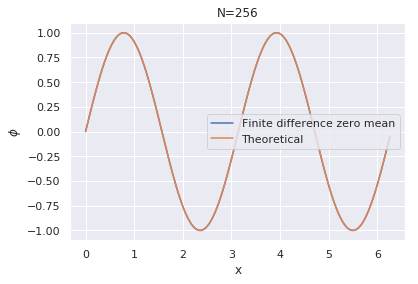

In [5]:
# constants
a = 0
b= 2*np.pi
rho = lambda x: 4*np.sin(2*x)
Ns = [8,16,32,64,128,256]
# theoretical answer
phiTeo = lambda x: np.sin(2*x)
# errors of the differenct cases (N x norm-type)
errors4th = np.zeros((6, 3))

for i, N in enumerate(Ns):
    h = (b-a)/N
    # now we need to append the last grid point
    xlist = [a+i*h for i in range(0,N)]
    phi = periodicSolverZeroMean(a=a, b=b, N=N, rho=rho)
    # the theoretical value of phi - done this way because of shape problems
    phiT = np.array([phiTeo(x) for x in xlist])
    
    errors4th[i,0] = np.linalg.norm(phi - phiT, ord=1)
    errors4th[i,1] = np.linalg.norm(phi - phiT, ord=2)
    errors4th[i,2] = np.linalg.norm(phi - phiT, ord=np.inf)
    
    # plotting stuff
    plt.figure()
    plt.title('N='+str(N))
    plt.xlabel('x')
    plt.ylabel('$\phi$')
    plt.plot(xlist, phi)
    plt.plot(xlist, phiT)
    plt.legend(['Finite difference zero mean', 'Theoretical'])
    plt.grid(True)

2) Fourier spectral collocation method using Fast fourier transform

In [6]:
def fftSolver(a, b, N, rho, alpha=0):
    h = (b-a)/N
    xlist = [a+i*h for i in range(N)]
    rightSide = np.array([rho(x) for x in xlist])
    # find the discrete fourier transform of the rightside
    fks = np.fft.fft(rightSide)
    # shift the transform to be like (-2, -1, 0, 1, 2)
    fks = np.fft.fftshift(fks)

    # calculate coeff. Remember to use complex matrix
    aks = np.zeros(N, dtype=complex)
    for i, k in enumerate([k for k in range(-round(N/2),round(N/2))]):
        if(k==0):
            aks[i]=alpha
        else:       
            # no need for a shift of coeffs, since this is already done
            aks[i]=fks[i]/((2*k*np.pi/(b-a))**2)
    aks = np.fft.fftshift(aks)
    x = np.fft.ifft(aks)
    return x

Lets test it

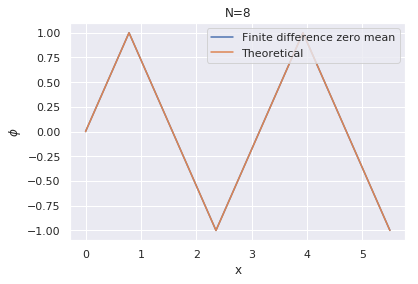

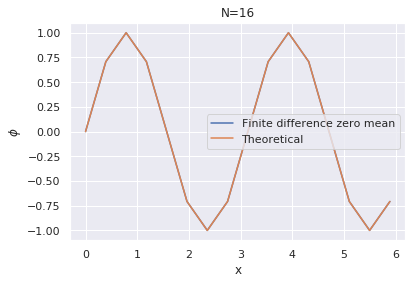

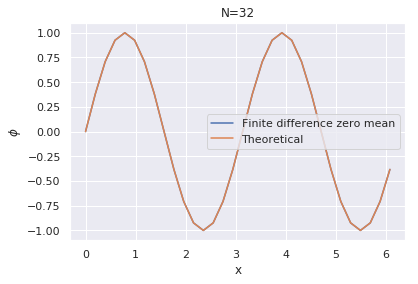

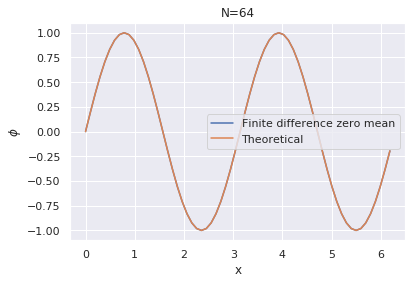

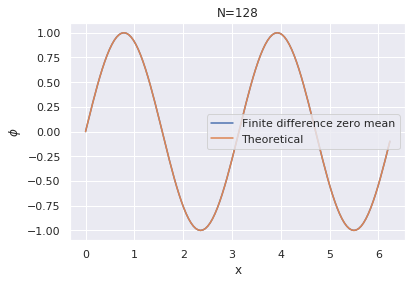

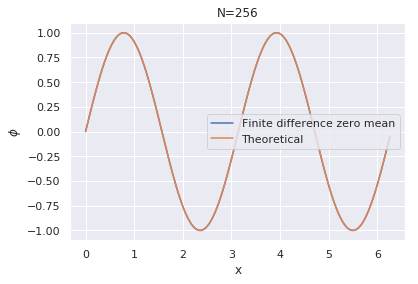

In [7]:
# constants
a = 0
b= 2*np.pi
rho = lambda x: 4*np.sin(2*x)
Ns = [8,16,32,64,128,256]
# theoretical answer
phiTeo = lambda x: np.sin(2*x)
# errors of the differenct cases (N x norm-type)
errorsFft = np.zeros((6, 3))

for i, N in enumerate(Ns):
    h = (b-a)/N
    # now we need to append the last grid point
    xlist = [a+i*h for i in range(0,N)]
    phi = fftSolver(a=a, b=b, N=N, rho=rho)
    # the theoretical value of phi - done this way because of shape problems
    phiT = np.array([phiTeo(x) for x in xlist])
    
    errorsFft[i,0] = np.linalg.norm(phi - phiT, ord=1)
    errorsFft[i,1] = np.linalg.norm(phi - phiT, ord=2)
    errorsFft[i,2] = np.linalg.norm(phi - phiT, ord=np.inf)
    
    # plotting stuff
    plt.figure()
    plt.title('N='+str(N))
    plt.xlabel('x')
    plt.ylabel('$\phi$')
    plt.plot(xlist, np.real(phi))
    plt.plot(xlist, phiT)
    plt.legend(['Finite difference zero mean', 'Theoretical'])
    plt.grid(True)

c) method of manufactored solutions

first we test the FD solution with the suggested test function. Sympy is used for differentiation.


$$\phi (x) = \cos{(\frac{2 \pi x}{L})}\exp{(\sin{(\frac{2 \pi x}{L})})}$$

Here is the implementation with 4th derivative

This is the smallest eigval
0.9959984483561433
This is the smallest eigval
0.9997393731716193
This is the smallest eigval
0.9999835418044016
This is the smallest eigval
0.9999989687039642
This is the smallest eigval
0.9999999355021563
This is the smallest eigval
0.9999999959691354


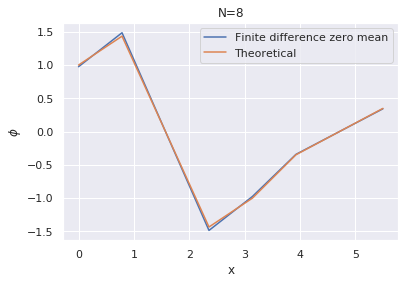

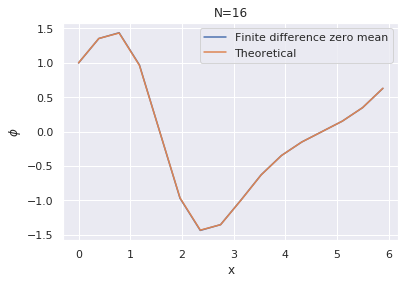

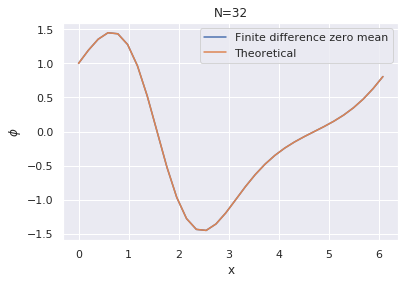

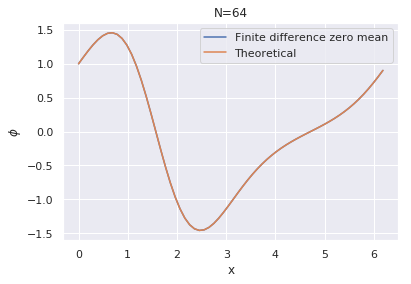

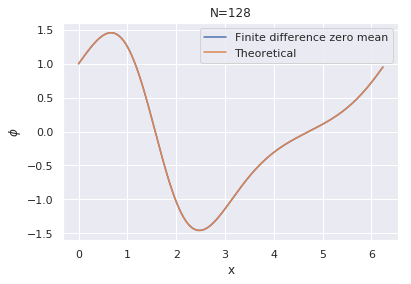

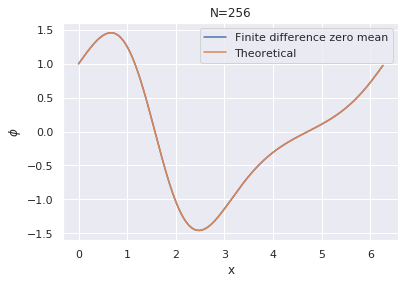

In [8]:
# constants
a = 0
b= 2*np.pi
Ns = [8,16,32,64,128,256]
# theoretical answer
z = Symbol('z')
phiTeo = cos(2*pi*z/(b-a))*exp(sin(2*pi*z/(b-a)))
rho = -diff(diff(phiTeo))
phiTeoLambda = lambdify(z, phiTeo)
rhoLambda = lambdify(z, rho)

# errors of the differenct cases (N x norm-type)
errors4th = np.zeros((6, 3))

for i, N in enumerate(Ns):
    h = (b-a)/N
    # now we need to append the last grid point
    xlist = [a+i*h for i in range(0,N)]
    phi = periodicSolverZeroMean(a=a, b=b, N=N, rho=rhoLambda)
    # the theoretical value of phi - done this way because of shape problems
    phiT = np.array([phiTeoLambda(x) for x in xlist])
    
    errors4th[i,0] = np.linalg.norm(phi - phiT, ord=1)
    errors4th[i,1] = np.linalg.norm(phi - phiT, ord=2)
    errors4th[i,2] = np.linalg.norm(phi - phiT, ord=np.inf)
    
    # plotting stuff
    plt.figure()
    plt.title('N='+str(N))
    plt.xlabel('x')
    plt.ylabel('$\phi$')
    plt.plot(xlist, phi)
    plt.plot(xlist, phiT)
    plt.legend(['Finite difference zero mean', 'Theoretical'])
    plt.grid(True)

Try the manufactored solution with the fourier spectral collocation method

0.303963550927013*pi**2*exp(sin(0.318309886183791*pi*z))*sin(0.318309886183791*pi*z)*cos(0.318309886183791*pi*z) - 0.101321183642338*pi**2*exp(sin(0.318309886183791*pi*z))*cos(0.318309886183791*pi*z)**3 + 0.101321183642338*pi**2*exp(sin(0.318309886183791*pi*z))*cos(0.318309886183791*pi*z)


/home/martin/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


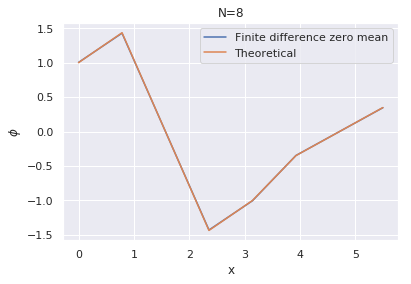

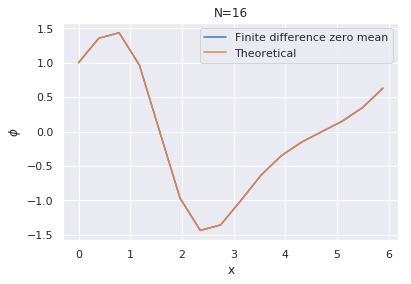

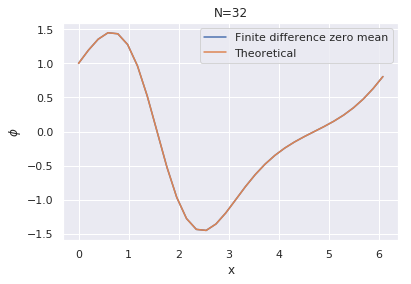

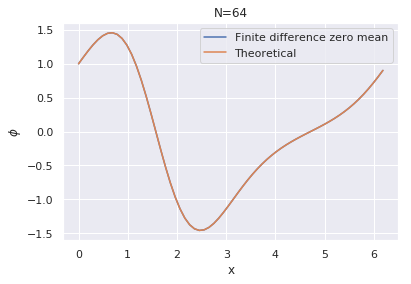

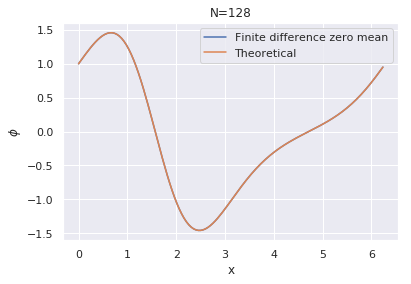

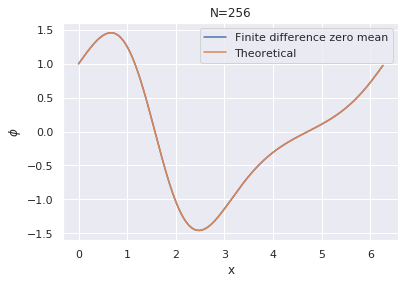

In [9]:
# constants
a = 0
b= 2*np.pi
Ns = [8,16,32,64,128,256]
# theoretical answer
z = Symbol('z')
phiTeo = cos(2*pi*z/(b-a))*exp(sin(2*pi*z/(b-a)))
rho = -diff(diff(phiTeo))
print(rho)
phiTeoLambda = lambdify(z, phiTeo)
rhoLambda = lambdify(z, rho)

# errors of the differenct cases (N x norm-type)
errorsfft = np.zeros((6, 3))

for i, N in enumerate(Ns):
    h = (b-a)/N
    # now we need to append the last grid point
    xlist = [a+i*h for i in range(0,N)]
    phi = fftSolver(a=a, b=b, N=N, rho=rhoLambda)
    # the theoretical value of phi - done this way because of shape problems
    phiT = np.array([phiTeoLambda(x) for x in xlist])
    
    errorsfft[i,0] = np.linalg.norm(phi - phiT, ord=1)
    errorsfft[i,1] = np.linalg.norm(phi - phiT, ord=2)
    errorsfft[i,2] = np.linalg.norm(phi - phiT, ord=np.inf)
    
    # plotting stuff
    plt.figure()
    plt.title('N='+str(N))
    plt.xlabel('x')
    plt.ylabel('$\phi$')
    plt.plot(xlist,phi)
    plt.plot(xlist, phiT)
    plt.legend(['Finite difference zero mean', 'Theoretical'])
    plt.grid(True)

test the same function on the second order FD scheme

In [10]:
def systemMatrixSecondOrder(N, a, b):
    h=(b-a)/N
    firstRow = np.zeros(N)
    firstRow[0:2] = [ -2, 1]
    firstRow[-1]=1
    # using the scipy circulant function
    A = circulant(firstRow)
    A *= -1/h**2
    # now we set the last row to 1's to make the average zero
    A[-1]=np.ones(N)
    print('This is the smallest eigval')
    print(min(abs(np.linalg.eigvals(A))))
    return A

In [11]:
def periodicSolverZeroMeanSecondOrder(a, b, N, rho):
    h = (b-a)/N
    A = systemMatrixSecondOrder(N=N, a=a, b=b)
    xlist = [a+i*h for i in range(N-1)]
    rightSide = np.array([rho(x) for x in xlist])
    # remember to set the last row equal to 0
    rightSide = np.append(rightSide, [0])
    x = np.linalg.solve(A,rightSide)
    return x

This is the smallest eigval
0.9496412035517829
This is the smallest eigval
0.9872148307666587
This is the smallest eigval
0.9967913640449589
This is the smallest eigval
0.9991970675392179
This is the smallest eigval
0.9997992185116793
This is the smallest eigval
0.9999498016048952


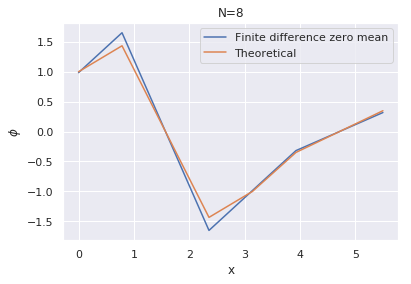

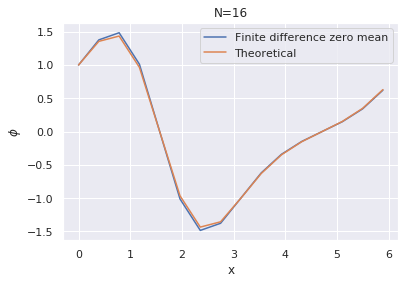

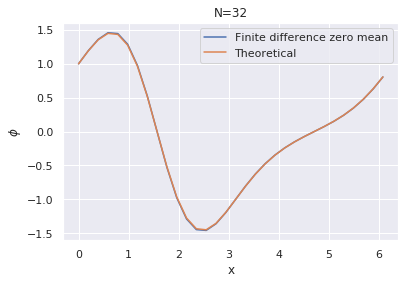

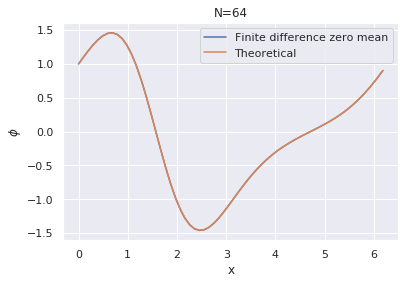

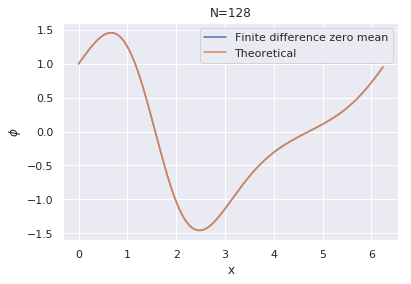

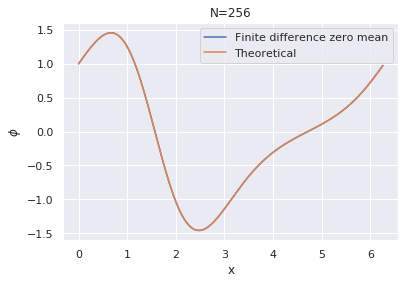

In [12]:
# constants
a = 0
b= 2*np.pi
Ns = [8,16,32,64,128,256]
# theoretical answer
z = Symbol('z')
phiTeo = cos(2*pi*z/(b-a))*exp(sin(2*pi*z/(b-a)))
rho = -diff(diff(phiTeo))
phiTeoLambda = lambdify(z, phiTeo)
rhoLambda = lambdify(z, rho)

# errors of the differenct cases (N x norm-type)
errors2nd = np.zeros((6, 3))

for i, N in enumerate(Ns):
    h = (b-a)/N
    # now we need to append the last grid point
    xlist = [a+i*h for i in range(0,N)]
    phi = periodicSolverZeroMeanSecondOrder(a=a, b=b, N=N, rho=rhoLambda)
    # the theoretical value of phi - done this way because of shape problems
    phiT = np.array([phiTeoLambda(x) for x in xlist])
    
    errors2nd[i,0] = np.linalg.norm(phi - phiT, ord=1)
    errors2nd[i,1] = np.linalg.norm(phi - phiT, ord=2)
    errors2nd[i,2] = np.linalg.norm(phi - phiT, ord=np.inf)
    
    # plotting stuff
    plt.figure()
    plt.title('N='+str(N))
    plt.xlabel('x')
    plt.ylabel('$\phi$')
    plt.plot(xlist, phi)
    plt.plot(xlist, phiT)
    plt.legend(['Finite difference zero mean', 'Theoretical'])
    plt.grid(True)

d)  convergence plot for h-> 0 for the second order FD scheme, 4th order and Fourier spectral. There seems to be no observable difference in the error for each

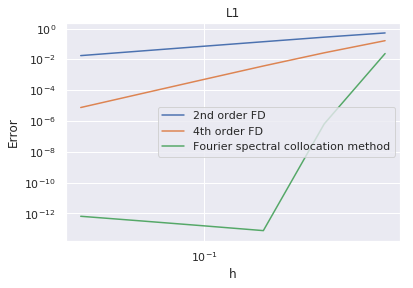

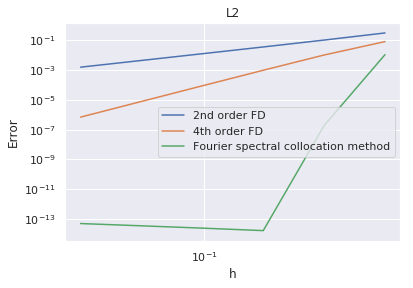

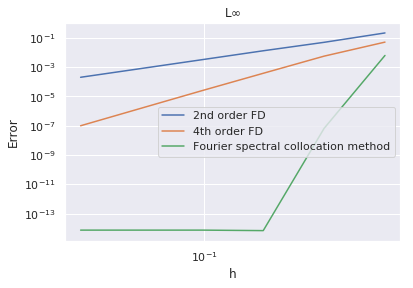

In [15]:
for i, errorType in enumerate(['L1','L2','L$\infty$']):
    plt.figure()
    plt.loglog([(b-a)/N for N in Ns], errors2nd[:,i])
    plt.loglog([(b-a)/N for N in Ns], errors4th[:,i])
    plt.loglog([(b-a)/N for N in Ns], errorsfft[:,i])
    plt.grid(True)
    plt.xlabel('h')
    plt.ylabel('Error')
    plt.title(errorType)
    plt.legend(['2nd order FD', '4th order FD', 'Fourier spectral collocation method'])

# As one can see, the fourier method has an error less than machine precision until after h=0.1, so 
# it's an amazing method